In [74]:
import pandas as pd
import matplotlib.pyplot as plt
correct_color = "b"
incorrect_color = "r"

In [75]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_distribution(processed_df, title):
    df = processed_df.copy()
    df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100, color=correct_color)
    df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100, color=incorrect_color)
    plt.title(f'{title}\nPredict Probability Distribution\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Correct', 'Incorrect'])
    plt.show()

def show_stackdistribution(processed_df, title):
    df = processed_df.copy()
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Stacking Distribution\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.show()

def show_stackdistributionsumation(processed_df, title):
    df = processed_df.copy()
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    # Sumation
    df['correct'] = df['correct'].cumsum()
    df['incorrect'] = df['incorrect'].cumsum()

    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Sumation Probability Stacking Distribution\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.show()

In [76]:
cnn1d_raw_df = pd.read_csv('cnn1d/predict.csv', index_col=0).drop(columns=["true"])
convbbt_raw_df = pd.read_csv('convbbt/predict.csv', index_col=0).drop(columns=["true"])
vit_raw_df = pd.read_csv('vit/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('convbbt/predict.csv', index_col=0)["true"]

In [77]:
cnn1d_raw_df.head()

,0,1,2,3,4,5
0,-24.943642,-14.376371,-30.270120,-34.804478,3.497355,8.651757
1,-41.976780,-51.831050,31.597225,0.572858,-34.029915,-22.983843
2,-10.403299,-20.507471,-35.264004,-31.831710,11.764874,-4.416489
3,-5.945934,22.957941,-33.201534,-32.098297,-3.378157,-19.997862
4,-14.173546,-47.217030,1.452709,18.719597,-17.833082,-30.701788


In [78]:
convbbt_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [79]:
vit_raw_df.head()

,0,1,2,3,4,5
0,3.011206,-5.817851,-5.217103,-7.638794,0.831200,9.454015
1,1.910253,-6.772700,15.421850,2.738583,-5.358047,-3.725187
2,-1.027743,-7.089542,-5.357136,-3.138410,12.560061,1.079521
3,-2.923320,15.512492,-7.420484,-7.753412,1.668159,-0.424469
4,1.624771,-4.469953,-0.402944,15.373968,-4.972460,-5.154066


In [80]:
cnn1d_df = preprocess_df(cnn1d_raw_df, true_label)
convbbt_df = preprocess_df(convbbt_raw_df, true_label)
vit_df = preprocess_df(vit_raw_df, true_label)

In [81]:
cnn1d_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.084583,0.175226,0.038894,0.000000,0.328542,0.372755,0.372755,Walking,Walking
1,0.051235,0.000000,0.433766,0.272462,0.092553,0.149984,0.433766,Sitting,Sitting
2,0.205586,0.122030,0.000000,0.028383,0.388906,0.255094,0.388906,Upstairs,Upstairs
3,0.213693,0.440310,0.000000,0.008650,0.233826,0.103521,0.440310,Jogging,Jogging
4,0.170724,0.000000,0.251459,0.340671,0.151817,0.085328,0.340671,Standing,Standing


In [82]:
convbbt_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


In [83]:
vit_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.263253,0.045011,0.059861,0.000000,0.209366,0.422510,0.422510,Walking,Walking
1,0.193596,0.000000,0.494851,0.212064,0.031541,0.067948,0.494851,Sitting,Sitting
2,0.153215,0.000000,0.043787,0.099867,0.496654,0.206477,0.496654,Upstairs,Upstairs
3,0.106909,0.514967,0.007369,0.000000,0.208537,0.162219,0.514967,Jogging,Jogging
4,0.205895,0.020779,0.144307,0.623503,0.005516,0.000000,0.623503,Standing,Standing


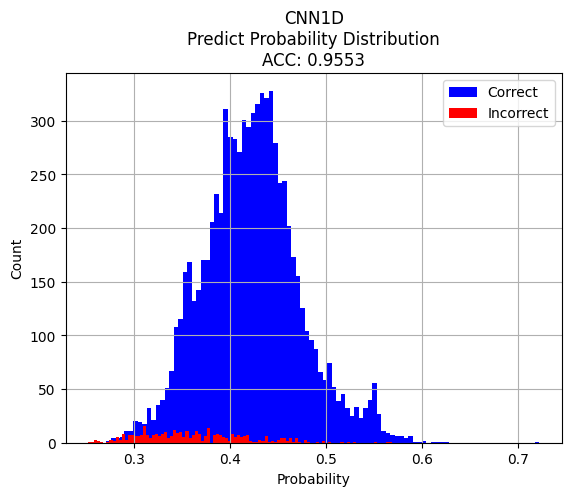

In [84]:
show_distribution(cnn1d_df, 'CNN1D')

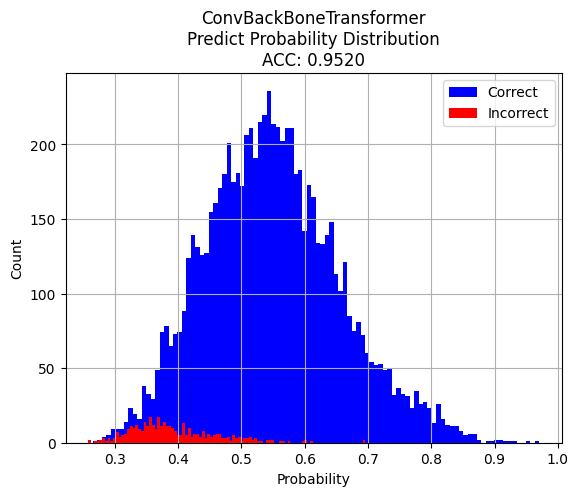

In [85]:
show_distribution(convbbt_df, 'ConvBackBoneTransformer')

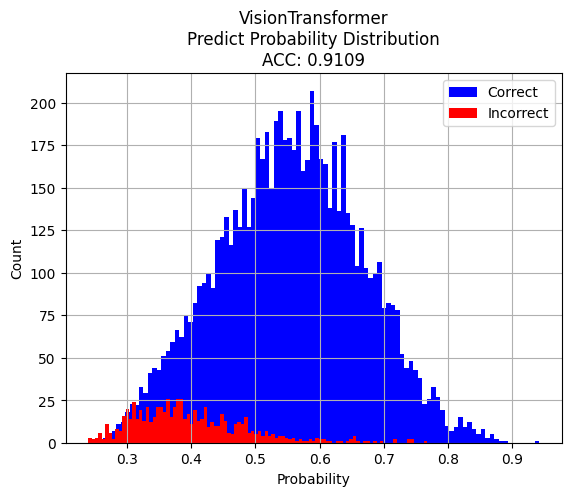

In [86]:
show_distribution(vit_df, 'VisionTransformer')

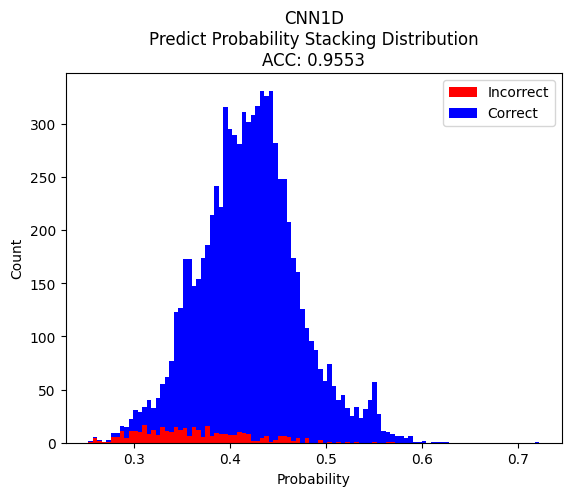

In [87]:
show_stackdistribution(cnn1d_df, 'CNN1D')

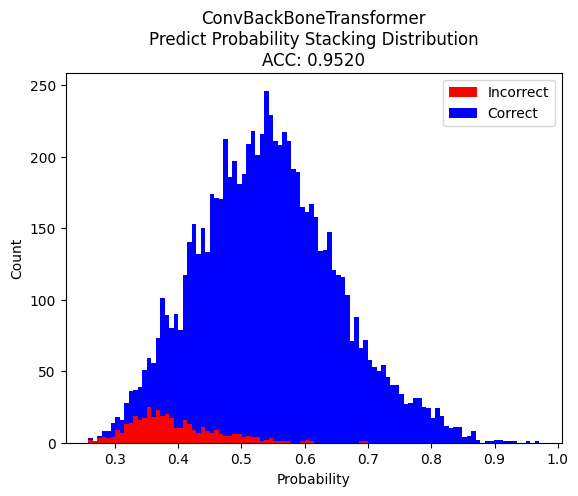

In [88]:
show_stackdistribution(convbbt_df, 'ConvBackBoneTransformer')

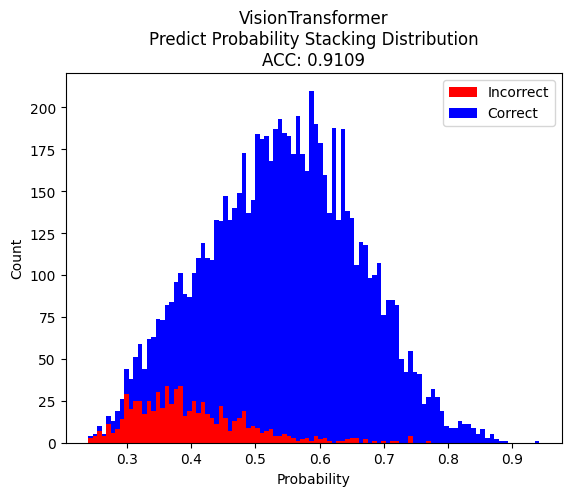

In [89]:
show_stackdistribution(vit_df, 'VisionTransformer')

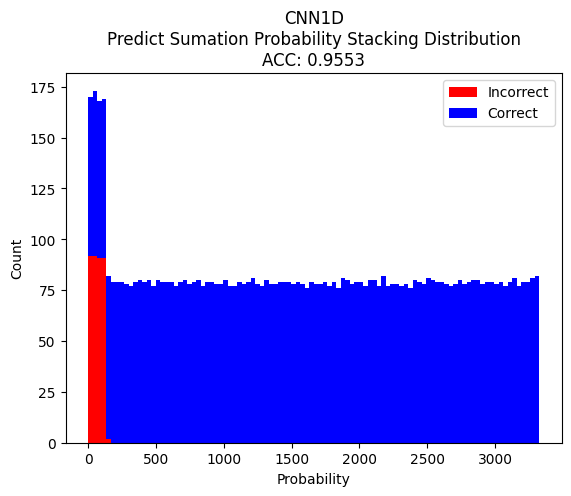

In [90]:
show_stackdistributionsumation(cnn1d_df, 'CNN1D')

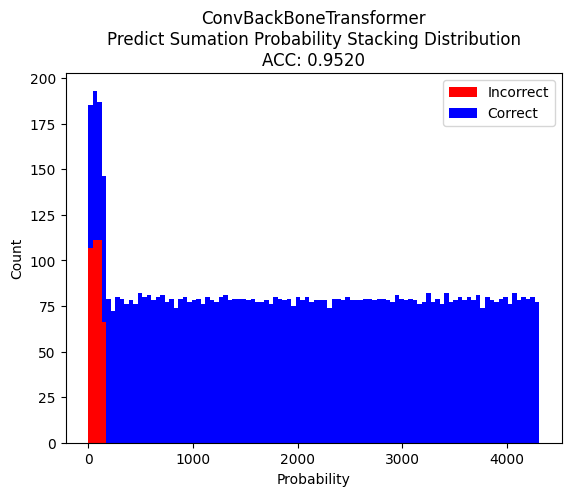

In [91]:
show_stackdistributionsumation(convbbt_df, 'ConvBackBoneTransformer')

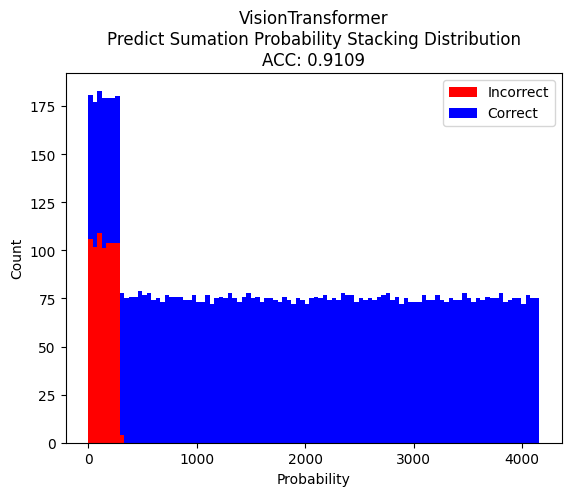

In [92]:
show_stackdistributionsumation(vit_df, 'VisionTransformer')